# imports

In [1]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics.SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist, euclidean


from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *
from PhenotypicData.PhenotypeGenerationFunctions import *
from CardioProject.CardioFunctions import *
from PredictionPipeline.PredictionFunctions import *
from TCR_feature_generation.SubsamplingFunctions import *

import os
from Utils import cacheOnDisk
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

#ML imports:
from xgboost import XGBClassifier,XGBRegressor
import lightgbm as lgb
from collections import OrderedDict
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
import shap
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif,f_classif
from sklearn.naive_bayes import GaussianNB

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126


done1
stop
stop
done1
stop
done
done
done
done
stop
stop
end of function!!!


/usr/wisdom/python/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


end of function!!!


In [2]:
import time
cdate=str(time.strftime("%d%m%Y"))
cdate

'13112018'

# correcting (again) TCR features for major phenotypes using regression

1. write new module for that
2. test this module for age
3. compare results to old resuls and see if there is a problem (correcting features which should be corrected)
4. if exerything is ok, correct for age, age+gender, age+gender+eGFR
5. if #4, repeat major phenotype prediction using the corrected features

## test new correction module

In [ ]:
!python /home/sbenari/workspace/Microbiome/ShaniBA/TCR_feature_generation/FeatureCorrection_byLinReg.py \
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_noT.dat \
-path_to_phenotype_DF /net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PNP530Cardio126Combined/Phenotypes/PNP530Cardio126_AllInfo_withDummies.xlsx \
-phen_list '["Age","Gender_Male","eGFR by CKD-EPI"]' 


### check age prediction paradox


#### check dataframes

In [ ]:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_noT_AgeCorr.dat'
allTCRfeatures_percShared10__withRels_noT_AgeCorr=pd.read_pickle(f1)
allTCRfeatures_percShared10__withRels_noT_AgeCorr.head()

In [ ]:
allTCRfeatures_percShared10__withRels_noT_AgeCorr.shape

In [ ]:
allTCRfeatures_percShared10__withRels_noT_AgeCorr.columns.tolist()

In [ ]:
f2='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/predictions2/\
TargetDFs/PNP530_majorPhenotypes_contOnly.xlsx'
phenDF=pd.read_excel(f2).set_index('BD')
phenDF.head()

In [ ]:
phenDF.shape

In [ ]:
phenDF[phenDF['Age'].notnull()].shape

In [ ]:
for col in allTCRfeatures_percShared10__withRels_noT_AgeCorr.columns:
    r,p=MyPearsonr(phenDF['Age'].loc[allTCRfeatures_percShared10__withRels_noT_AgeCorr.index],
                   allTCRfeatures_percShared10__withRels_noT_AgeCorr[col])
    if p<0.05:
        print col,round(r,2),round(p,6)

In [ ]:
for col in allTCRfeatures_percShared10__withRels_noT_AgeCorr.columns:
    print col

#### use old prediction functions and see if the problem exist:

In [ ]:
#get dfs:
#phen:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PNP530Cardio126Combined/Phenotypes/\
PNP530Cardio126_AllInfo_withDummies.xlsx'
phenDF=pd.read_excel(f1).set_index('BD')
phenDF=phenDF['Age']

#features:
folder='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/'
X_file_list=['allTCRfeatures_percShared10__withRels_noT_AgeCorr.dat','allTCRfeatures_percShared10__withRels_noT.dat']

#result folder:
resultFolder='%s/TCR_real_data/predictions2/PNP530_majorPhenotypes/oldPredictionTrial/' %MyPath

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
# with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
#     Cardio126=pickle.load(fp)
# PNP530Cardio126=PNP530+Cardio126


model=XGBRegressor
modelName='XGBRegressor'
featureSelectionMethod_list=[None]         
k_list=[10]
task='reg'

for X_file in X_file_list:
    X=pd.read_pickle(folder+X_file).loc[PNP530,:]

    targetDF=phenDF                     
 
    Xname=X_file
    Y=targetDF
    Y=Y.loc[PNP530].dropna()
    X=X.loc[Y.index,:]
    
    print ('X shape: ', X.shape)
    print ('Y shape: ', Y.shape)

    max_depth_list=[3]
    learninglist=[(0.01,1000)]
    gamma_list=[1]
    subsample_list=[0.7]
    reg_alpha_list=[10]
    for learning in learninglist:
        learning_rate=learning[0]
        n_estimators=learning[1]
        
        
        for max_depth in max_depth_list:
            for gamma in gamma_list:
                for reg_alpha in reg_alpha_list:
                    for subsample in subsample_list:
            
                        model_params={'learning_rate': learning_rate, 'n_estimators': n_estimators,
                        'max_depth': max_depth,'num_threads':2,'bagging_fraction':0.5,'bagging_freq':1,
                        'bagging_seed':3,'gamma':gamma,'reg_alpha':reg_alpha,'subsample':subsample}


                        run_old_classification(X,Xname, Y, k_list,model, modelName,model_params,task,
                                           resultFolder,featureSelectionMethod_list)
    

In [ ]:
folder='%s/TCR_real_data/predictions2/PNP530_majorPhenotypes/oldPredictionTrial/Age' %MyPath
df_folder='%s/resultDFs' %folder

results=concat_summarizing_dfs_excel(df_folder)
results=results.sort_values(by='p_pear')
nTests=len(results) 
FDR=0.1
results=add_corrected_pValues(results,'p_pear',nTests,FDR)
f1='%s/resultSummary_%s.xlsx' %(folder,cdate)
results.to_excel(f1)


### implement Noam's function:

In [ ]:
def compute_linear_regression(X, Y):
    from tqdm import tnrange, tqdm_notebook
    res = pd.DataFrame(index=Y.columns, columns=['Number of samples', 'intercept', 'MSE', 'r2_Score',
                                                 'real-predicted pearson_r', 'real-predicted pearson_p',
                                                 'coefficient of determination'] + [str(c) for c in X.columns])
    residuals = pd.DataFrame(columns=X.index)
    for i in tqdm_notebook(range(Y.shape[1]), desc='LR'):
        y = Y.iloc[:, i].copy()
        xy = pd.concat((X, y), axis=1).dropna()
        y = y.loc[xy.index]
        X_temp = X.loc[xy.index].copy()
 
        regr = LinearRegression()
        regr.fit(X_temp, y)
        y_pred = regr.predict(X_temp)
        res.loc[Y.columns[i], 'Number of samples'] = xy.shape[0]
        for c in range(X.shape[1]):
            res.loc[Y.columns[i], X.columns[c]] = regr.coef_[c]
        res.loc[Y.columns[i], 'intercept'] = regr.intercept_
        res.loc[Y.columns[i], 'MSE'] = metrics.mean_squared_error(y_pred, y)
        res.loc[Y.columns[i], 'r2_Score'] = metrics.r2_score(y_pred, y)
        r, p = pearsonr(y, y_pred)
        res.loc[Y.columns[i], 'real-predicted pearson_r'] = r
        res.loc[Y.columns[i], 'real-predicted pearson_p'] = p
        res.loc[Y.columns[i], 'coefficient of determination'] = regr.score(X_temp, y)
        residuals = pd.concat((residuals, pd.DataFrame(y - y_pred).T))
        
    residuals.columns.name = Y.index.name
    residuals.index.name = Y.columns.name
    return res, residuals

In [ ]:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PNP530Cardio126Combined/Phenotypes/\
PNP530Cardio126_AllInfo_withDummies.xlsx'
phenDF=pd.read_excel(f1).set_index('BD')
AgePNP530=pd.DataFrame(phenDF.loc[PNP530,'Age'])
AgePNP530=AgePNP530.fillna(AgePNP530['Age'].median())

f2='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/allTCRfeatures_percShared10__withRels_noT.dat'
featureDF=pd.read_pickle(f2)
featureDF=featureDF.loc[PNP530,:]
for col in featureDF.columns:
    if 'norm' in col:
        featureDF[col]=featureDF[col].fillna(featureDF[col].median())
    else:
        featureDF[col]=featureDF[col].fillna(0)

X=AgePNP530
Y=featureDF

res, residuals=compute_linear_regression(X, Y)

In [ ]:
res

In [ ]:
residuals

In [ ]:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/residuals_Age.dat'
residuals.T.to_pickle(f1)

#### compare noam's resdiual's to mine:

In [ ]:
# get dfs:
#phen:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PNP530Cardio126Combined/Phenotypes/\
PNP530Cardio126_AllInfo_withDummies.xlsx'
phenDF=pd.read_excel(f1).set_index('BD').loc[PNP530,:]
phenDF=phenDF['Age']

#features:
folder='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/'
X_corr_file='allTCRfeatures_percShared10__withRels_noT_AgeCorr.dat'
X_corr=pd.read_pickle(folder+X_corr_file).loc[PNP530,:]
# X_corr=X_corr.loc[PNP530,:]

X_file='allTCRfeatures_percShared10__withRels_noT.dat'
X=pd.read_pickle(folder+X_file).loc[PNP530,:]

In [ ]:
col='simpson_nt_1'
data1=phenDF.loc[X.index]
data1name='Age'

fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(12,8))
plt.suptitle(col,fontsize='xx-large')

for n in range(6):
    print n
    ax=axes.flatten()[n]
    if n%3==0:
        data2name=col
        data2=X[data2name]
        print len(data2)
        title='Not corrected'
       
        
    elif n%3==1:
        data2name=col+'_AgeCorrRes'
        data2=X_corr[data2name]
        print len(data2)
        title='Corrected'
      
    elif n%3==2:
        data2name=col
        data2=residuals.T[data2name]
        print len(data2)
        title='Corrected-Noam'
    
    if n<3:
        corrType='pearson'
    else:
        corrType='spearman'
        title='' 
        
    ax, nsamples,r,p,text=plot_corr(data1,data2,data1name,data2name,ax,title,corrType=corrType)
    ax.set_ylabel('')
    if n<3:
        ax.set_xlabel('')
        
plt.show()

In [ ]:
col='top10clonal_aa_1'
data1=phenDF.loc[X.index]
data1name='Age'

fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(12,8))
plt.suptitle(col,fontsize='xx-large')

for n in range(6):
    print n
    ax=axes.flatten()[n]
    if n%3==0:
        data2name=col
        data2=X[data2name]
        print len(data2)
        title='Not corrected'
       
        
    elif n%3==1:
        data2name=col+'_AgeCorrRes'
        data2=X_corr[data2name]
        print len(data2)
        title='Corrected'
      
    elif n%3==2:
        data2name=col
        data2=residuals.T[data2name]
        print len(data2)
        title='Corrected-Noam'
    
    if n<3:
        corrType='pearson'
    else:
        corrType='spearman'
        title='' 
        
    ax, nsamples,r,p,text=plot_corr(data1,data2,data1name,data2name,ax,title,corrType=corrType)
    ax.set_ylabel('')
    if n<3:
        ax.set_xlabel('')
        
plt.show()

In [ ]:
col='HSV_rel_cum_freq(perc)'
data1=phenDF.loc[X.index]
data1name='Age'

fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(12,8))
plt.suptitle(col,fontsize='xx-large')

for n in range(6):
    print n
    ax=axes.flatten()[n]
    if n%3==0:
        data2name=col
        data2=X[data2name]
        print len(data2)
        title='Not corrected'
       
        
    elif n%3==1:
        try:
            data2name=col+'_AgeCorrRes'
            data2=X_corr[data2name]
            print len(data2)
            title='Corrected'
        except:
            print 'no corrected column'
      
    elif n%3==2:
        data2name=col
        data2=residuals.T[data2name]
        print len(data2)
        title='Corrected-Noam'
    
    if n<3:
        corrType='pearson'
    else:
        corrType='spearman'
        title='' 
        
    ax, nsamples,r,p,text=plot_corr(data1,data2,data1name,data2name,ax,title,corrType=corrType,alpha=0.5)
    ax.set_ylabel('')
    if n<3:
        ax.set_xlabel('')
        
plt.show()

# predicting age using different X matrices:

matrices used:
1. all seqs present in >10% samples
2. all seqs present in >10% samples+repertoire and annotation features
3. repertoire and annotation features
4. baseline - WBC and nTemplates only
5. control - repertoire and annotation features corrected for age
6. control - repertoire and annotation features corrected for age,gender and eGFR

## get r and p values from each X:

In [31]:
result_folder='%s/TCR_real_data/predictions2/PNP530_majorPhenotypes' %MyPath
dirs=os.listdir(result_folder)
dirs

['lin_cont_gridSearch_25_byRepFeatRelsSmall_AgeCorr',
 'XGB_randomSearch_25_byVDJonly_ageCorr',
 'lin_cont_randomSearch_25_byVDJ',
 'XGB_randomSearch_25_byVDJ',
 'oldPredictionTrial',
 'XGB_randomSearch_25_byseqs10only',
 'XGB_randomSearch_25_byRepFeatRelsSmall',
 'XGB_randomSearch_25_byAgeResiduals',
 'lin_cont_gridSearch_25_byRepFeatRelsSmall',
 'lin_cont_gridSearch_25_byRepFeatRelsSmall_GenderCorr',
 'XGB_randomSearch_25_byRepFeatRelsSeqs',
 'XGB_randomSearch_25_byRepFeatRelsCorrected',
 'XGB_randomSearch_25_byRepFeatSmall_ageCorr01',
 'XGB_randomSearch_25_byWBCnTemplates',
 'XGB_randomSearch_25_byRepFeatRels',
 'XGB_randomSearch_25_byRepFeatRelsSmall_GenderCorr',
 'XGB_randomSearch_25_byRepFeatRelsAgeCorrected',
 'XGB_randomSearch_25_byRepFeatRelsSmall_AgeCorr',
 'XGB_randomSearch_25_byVDJ_ageCorr',
 'LGBM_randomSearch_20_byVDJ_ageCorr']

In [52]:
dirs=['XGB_randomSearch_25_byRepFeatRelsSmall','XGB_randomSearch_25_byAgeResiduals',
      'XGB_randomSearch_25_byRepFeatSmall_AgeGenderEGFRCorr01','XGB_randomSearch_25_byRepFeatSmall_AgeGenderEGFRCorr001',
      'XGB_randomSearch_25_byVDJ', 'XGB_randomSearch_25_byVDJ_ageCorr',
      'XGB_randomSearch_25_byseqs10only','XGB_randomSearch_25_byWBCnTemplates']
# phen_list=[('Age',['Coefficient_of_determination','pearson_p','pearson_r','spearman_p','spearman_r']),('Gender_Male',['prevalence','AUC','Precision_Recall'])]
phen_list=[('Age',['Coefficient_of_determination','pearson_p','pearson_r','spearman_p','spearman_r'])]
for item in phen_list:
    phen=item[0]
    colList=item[1]
    print '**********************'
    print '*  '+phen
    print '**********************'
    print ''

    phen_df_list=[]
    for d in dirs:
        print '*******'+d+'*******'
        print ''
        print '--------'
        print 'PERFORMANCE'
        print '--------'
        f1='%s/%s/results_df.pkl' %(result_folder,d)
        results_df=pd.read_pickle(f1)
        phen_result=pd.DataFrame(results_df.loc[phen,colList])
        phen_result=phen_result.rename(columns={phen:d}).T
        phen_df_list.append(phen_result)
        print phen_result

        print '--------'
        print 'SHAP_VALUES'
        print '--------'
        f2='%s/%s/shap_values.pkl' %(result_folder,d)
        shap_values=pd.read_pickle(f2)

        for k,v in shap_values.items():
            if k ==phen:
    #         print k
    #         print '------------------------'
                print v.abs().sum().sort_values(ascending=False).head(20)
                impFeatures=v.abs().sum().sort_values(ascending=False).head(20)
            
        if phen == 'Age':
            sorting='pearson_r'
        else:
            sorting='AUC'
        phen_result_sum=pd.concat(phen_df_list).sort_values(by=sorting,ascending=False)
        print phen_result_sum
        
        




**********************
*  Age
**********************

*******XGB_randomSearch_25_byRepFeatRelsSmall*******

--------
PERFORMANCE
--------
                                       Coefficient_of_determination  \
XGB_randomSearch_25_byRepFeatRelsSmall                     0.305796   

                                          pearson_p pearson_r   spearman_p  \
XGB_randomSearch_25_byRepFeatRelsSmall  1.52042e-43  0.553018  3.17731e-42   

                                       spearman_r  
XGB_randomSearch_25_byRepFeatRelsSmall   0.545692  
--------
SHAP_VALUES
--------
PC2                         2100.252704
cdr3Length_std_1             350.039978
top1000clonal_aa_1           315.755721
jDeletion_mean_1             311.178757
d3Deletion_mean_1            295.383730
normSeqNums_per2000_NT_1     291.384995
n2Insertion_std_1            270.513503
PC1                          269.840390
totalAnnotatefreqs           227.591533
d3Deletion_std_0             220.384746
PC3                         

V06-04_1        1854.774971
V05_1            462.105748
V25_J02_1        427.123452
V13-01_1         373.589864
V19-01_1         368.954268
V05-01_1         314.775764
V18_J02_1        275.925598
V27-01_1         272.018582
V07-09_1         258.055013
V02_J02_0        253.294241
V05-05_1         252.618110
V25_1            212.832319
D01_J02-04_0     183.694499
V05_J02_1        168.946608
V13_J02_1        168.148675
V05-08_1         165.160187
D01_J01-05_1     135.295944
V13_J02_0        118.116085
J02-05_1         115.407927
D02_J02-02_0     115.002347
dtype: float64
                                                   Coefficient_of_determination  \
XGB_randomSearch_25_byAgeResiduals                                     0.995744   
XGB_randomSearch_25_byRepFeatSmall_AgeGenderEGF...                     0.701838   
XGB_randomSearch_25_byRepFeatSmall_AgeGenderEGF...                     0.696491   
XGB_randomSearch_25_byVDJ                                              0.344894   
XGB_random

In [53]:
phen_result_sum=pd.concat(phen_df_list).sort_values(by='pearson_r',ascending=False)
phen_result_sum

,Coefficient_of_determination,pearson_p,pearson_r,spearman_p,spearman_r
XGB_randomSearch_25_byAgeResiduals,0.995744,0,0.997926,0,0.998261
XGB_randomSearch_25_byRepFeatSmall_AgeGenderEGFRCorr01,0.701838,2.33598e-141,0.839761,1.09892e-147,0.849178
XGB_randomSearch_25_byRepFeatSmall_AgeGenderEGFRCorr001,0.696491,9.31129e-140,0.837278,7.97686e-146,0.846474
XGB_randomSearch_25_byVDJ,0.344894,1.71133e-50,0.588831,1.27839e-45,0.564181
XGB_randomSearch_25_byRepFeatRelsSmall,0.305796,1.52042e-43,0.553018,3.17731e-42,0.545692
XGB_randomSearch_25_byseqs10only,0.23308,3.7511e-32,0.482977,1.09673e-29,0.465414
XGB_randomSearch_25_byVDJ_ageCorr,0.126048,3.65054e-17,0.355714,1.38968e-16,0.349471
XGB_randomSearch_25_byWBCnTemplates,-0.0188756,0.36219,0.0297056,0.323736,0.0321693


In [54]:
folder='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/'
corr001file='allTCRfeatures_percShared10__withRels_noT_AgeCorr001.dat'
corr01file='allTCRfeatures_percShared10__withRels_noT_AgeCorr01.dat'
corr001=pd.read_pickle(folder+corr001file)
corr01=pd.read_pickle(folder+corr01file)

In [55]:
corr001.head()

,berger_aa_0,berger_nt_0,cdr3Length_max_0,cdr3Length_mean_0,cdr3Length_mean_1,cdr3Length_std_0,count (templates)_max_0,count (templates)_std_0,d3Deletion_mean_0,d3Deletion_std_0,...,top1000clonal_nt_1_AgeCorrRes,top10clonal_aa_0_AgeCorrRes,top10clonal_aa_1_AgeCorrRes,top10clonal_nt_0_AgeCorrRes,top10clonal_nt_1_AgeCorrRes,vDeletion_mean_1_AgeCorrRes,DENV_rel_seq_count_AgeCorrRes,totalAnnotateSeqs_AgeCorrRes,PC1_AgeCorrRes,PC2_AgeCorrRes
BD406,0.047619,0.005882,76.0,46.414634,43.849290,7.354225,15.0,0.565283,3.252313,2.687372,...,-0.144717,-0.082968,-0.097109,-0.116696,-0.094733,-0.056378,0.311464,-21.651816,-0.009961,0.006823
BD228,0.019465,0.006371,80.0,47.004652,43.906318,7.885490,28.0,0.904500,3.388731,2.668487,...,-0.078484,-0.081897,-0.049502,-0.059765,-0.047450,-0.026403,1.601166,19.607149,-0.003222,-0.033301
BD714,0.108108,0.096562,74.0,45.232720,43.485130,7.563116,382.0,9.150792,3.278937,2.692033,...,0.069605,0.018427,0.051463,0.151535,0.045553,-0.022286,-0.896652,-62.053844,-0.003876,0.051476
BD808,0.053691,0.004317,80.0,46.155560,43.812114,7.391590,24.0,0.745621,3.363263,2.723223,...,-0.044716,-0.046655,0.003230,-0.063838,0.003107,-0.048722,0.727577,56.745143,0.009281,0.016281
BD144,0.031320,0.027792,81.0,46.254953,43.639412,7.390437,164.0,3.190097,3.219682,2.726473,...,0.004739,-0.054835,0.006861,-0.013157,0.005799,-0.100580,-0.720251,74.515153,0.014334,0.058647


In [56]:
corr001cols=[x for x in corr001.columns if '_Age' in x]
print len(corr001cols)
corr01cols=[x for x in corr01.columns if '_Age' in x]
print len(corr01cols)

41
56


## get selected params:

In [ ]:
dirs=['XGB_randomSearch_25_byRepFeatRelsSmall','XGB_randomSearch_25_byRepFeatRelsSmall_GenderCorr','XGB_randomSearch_25_byRepFeatRelsSmall_AgeCorr',
     'XGB_randomSearch_25_byVDJ','XGB_randomSearch_25_byseqs10only','XGB_randomSearch_25_byWBCnTemplates']
phen_list=[('Age',['Coefficient_of_determination','pearson_p','pearson_r','spearman_p','spearman_r']),('Gender_Male',['prevalence','AUC','Precision_Recall'])]

for item in phen_list:
    phen=item[0]
    colList=item[1]
    print '**********************'
    print '*  '+phen
    print '**********************'
    print ''

    phen_df_list=[]
    for d in dirs:
        print '*******'+d+'*******'
        print ''
        print '--------'
        print 'selected prarams'
        print '--------'
        f1='%s/%s/selected_model_params.pkl' %(result_folder,d)
        selected_model_params=pd.read_pickle(f1)
        print selected_model_params['Age']

# using more stringent cutoff for correcting features

## correcting 

In [51]:
!python /home/sbenari/workspace/Microbiome/ShaniBA/TCR_feature_generation/FeatureCorrection_byLinReg.py \
/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/VDJ_no0-01rare.dat \
-path_to_phenotype_DF /net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PNP530Cardio126Combined/Phenotypes/PNP530Cardio126_AllInfo_withDummies.xlsx \
-FDR 0.1 -phen_list '["Age","Gender_Male","eGFR by CKD-EPI"]' 

stop
stop
done1
done
done
main
('Xfile: ', '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/VDJ_no0-01rare.dat')
('Xdir: ', '/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/')
('Xname: ', 'VDJ_no0-01rare')
X Index is already "bd" or no such column exist
('phenotypes to correct for are:', [u'Age', u'Gender_Male', u'eGFR by CKD-EPI'])
correcting VDJ_no0-01rare for Age
        Age
BD         
BD1     NaN
BD10   45.0
BD100  57.0
BD101  64.0
BD102  40.0
        Age
BD         
BD406  65.0
BD228  32.0
BD714  39.0
BD808  26.0
BD144  36.0
(u'Age series type:', dtype('float64'))
checking associations between Age and all TCR features:
number of phenotype unique values is Age    50
dtype: int64 and useCorrForBinary=Truetherefore correlation test is used
('number of features to correct is:', 60)
('the most significantly associated features are:', ['V06-04_1', 'V06_J02_1', 'V05_1', 'V25_J02_1', 'V25-01_1'])
0 V04_0
100 V18_J0

### an example for feature before and after correction for gender:

In [17]:
# get dfs:
#phen:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PNP530Cardio126Combined/Phenotypes/\
PNP530Cardio126_AllInfo_withDummies.xlsx'
phenDF=pd.read_excel(f1).set_index('BD').loc[PNP530,:]
phenDF=phenDF['Gender_Male']

#features:

folder='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/'
X_corr_gender_file='allTCRfeatures_percShared10__withRels_noT_Gender_MaleCorr.dat'
X_corr_gender=pd.read_pickle(folder+X_corr_gender_file).loc[PNP530,:]
# X_corr=X_corr.loc[PNP530,:]

X_file='allTCRfeatures_percShared10__withRels_noT.dat'
X=pd.read_pickle(folder+X_file).loc[PNP530,:]

0
530
530
530
1
530
530
530
2
no residuals file
530
530
3
530
530
530
4
530
530
530
5
no residuals file
530
530


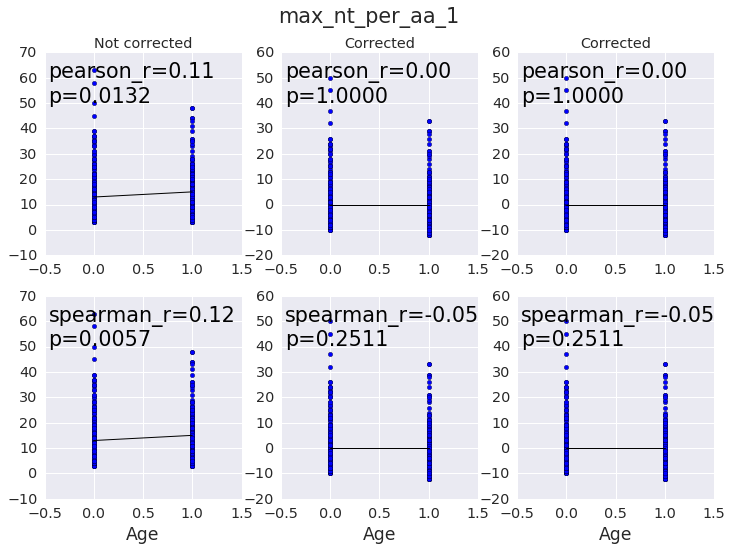

In [20]:
col='max_nt_per_aa_1'
data1=phenDF.loc[X.index]
data1name='Age'

fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(12,8))
plt.suptitle(col,fontsize='xx-large')

for n in range(6):
    print n
    ax=axes.flatten()[n]
    if n%3==0:
        data2name=col
        data2=X[data2name]
        print len(data2)
        title='Not corrected'
       
        
    elif n%3==1:
        data2name=col+'_Gender_MaleCorrRes'
        data2=X_corr_gender[data2name]
        print len(data2)
        title='Corrected'
      
    elif n%3==2:
        try:
            data2name=col
            data2=residuals.T[data2name]
            print len(data2)
            title='Corrected-Noam'
        except:
            print 'no residuals file'
    
    if n<3:
        corrType='pearson'
    else:
        corrType='spearman'
        title='' 
        
    ax, nsamples,r,p,text=plot_corr(data1,data2,data1name,data2name,ax,title,corrType=corrType)
    ax.set_ylabel('')
    if n<3:
        ax.set_xlabel('')
        
plt.show()

### comparing age distributions between women and man in the pnp530 cohort:

women are slightly but significantly older than men

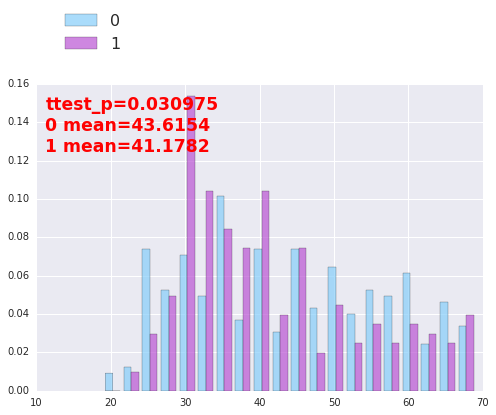

In [26]:
f1='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/PNP530Cardio126Combined/Phenotypes/\
PNP530Cardio126_AllInfo_withDummies.xlsx'
phenDF=pd.read_excel(f1).set_index('BD').loc[PNP530,:]

phenDFsmall=phenDF[['Age','Gender_Male']]
groups=phenDFsmall.groupby('Gender_Male')
dataList=[]
for name,group in groups:
    data[name]=group['Age'].dropna().tolist()
    tup=tuple([name, data[name]])
    dataList.append(tup)
#     print name, data[name]

fig,ax=plt.subplots()
title=''
plotHistComprison(dataList,ax,title,showLegend=True,nBins=20,toAnnotate=True,alpha=None,plotType='hist')
plt.show()

# use combined VDJ+rep features

regress for age using more stringent cut-off (q=0.01)

## combine VDJ+rep features

## regress using stringent cutoff for corrections

## predict age (and gender) using the corrected and the non-corrected features